<a href="https://colab.research.google.com/github/srinidhi183/CODE---SRINIDHI-/blob/StatsandML/Srinidhi_Sandeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

In this project, my main goal was to predict house prices using the 'House Prices - Advanced Regression Techniques' dataset. This dataset is rich in information about different house features, such as size, location, and quality, along with their corresponding sale prices. By analyzing these features, I aimed to build a robust regression model that could accurately estimate property prices while also providing meaningful insights into the factors driving house value.

**1. Importing Libraries and Loading Data**

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import shap

# Load the dataset
data = pd.read_csv("train.csv")  # Replace with your dataset path
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


** 2. Preprocessing**



To start with, I focused on preprocessing the data. I first addressed missing values by imputing numerical features like LotFrontage using the median and filling categorical features like GarageType with a new category or the mode. Then, I identified and capped outliers in the target variable SalePrice to ensure that extreme values didn't adversely affect the model. After handling outliers, I encoded categorical features using one-hot encoding and standardized all numerical features using StandardScaler to make them comparable in scale.

a) Handling Missing Values

In [8]:
# Check missing values
missing = data.isnull().sum()
print(missing[missing > 0])

# Impute missing values
data['LotFrontage'].fillna(data['LotFrontage'].median(), inplace=True)
data.fillna({'GarageType': 'None', 'GarageYrBlt': 0, 'GarageFinish': 'None'}, inplace=True)
# Only fill NaNs in numeric columns with the median
numeric_data = data.select_dtypes(include=np.number)
data[numeric_data.columns] = numeric_data.fillna(numeric_data.median())

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


<ipython-input-8-817748c3944d>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['LotFrontage'].fillna(data['LotFrontage'].median(), inplace=True)


b) Handle outliers

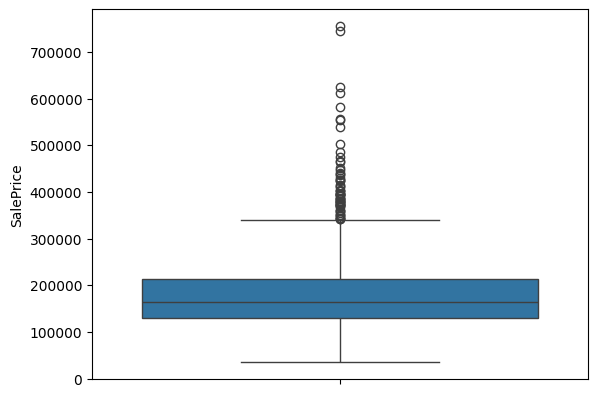

In [9]:
# Visualize outliers in SalePrice
sns.boxplot(data['SalePrice'])
plt.show()

# Cap extreme values
q1 = data['SalePrice'].quantile(0.25)
q3 = data['SalePrice'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data['SalePrice'] = np.where(data['SalePrice'] > upper_bound, upper_bound, data['SalePrice'])


c) Encode Categorical Variables

In [10]:
# One-hot encoding for categorical variables
data = pd.get_dummies(data, drop_first=True)


d) Scale Features

In [11]:
# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(['SalePrice'], axis=1))
X = pd.DataFrame(scaled_features, columns=data.drop(['SalePrice'], axis=1).columns)
y = data['SalePrice']


3. Feature Selection


Next, I moved to feature selection to identify the most impactful predictors. I first examined correlations using a heatmap to understand relationships between features. Then, I used Recursive Feature Elimination (RFE) with Linear Regression to systematically reduce the number of predictors while retaining the most important ones. This step helped me focus on the variables that contributed most to the model's performance, avoiding redundancy and noise.



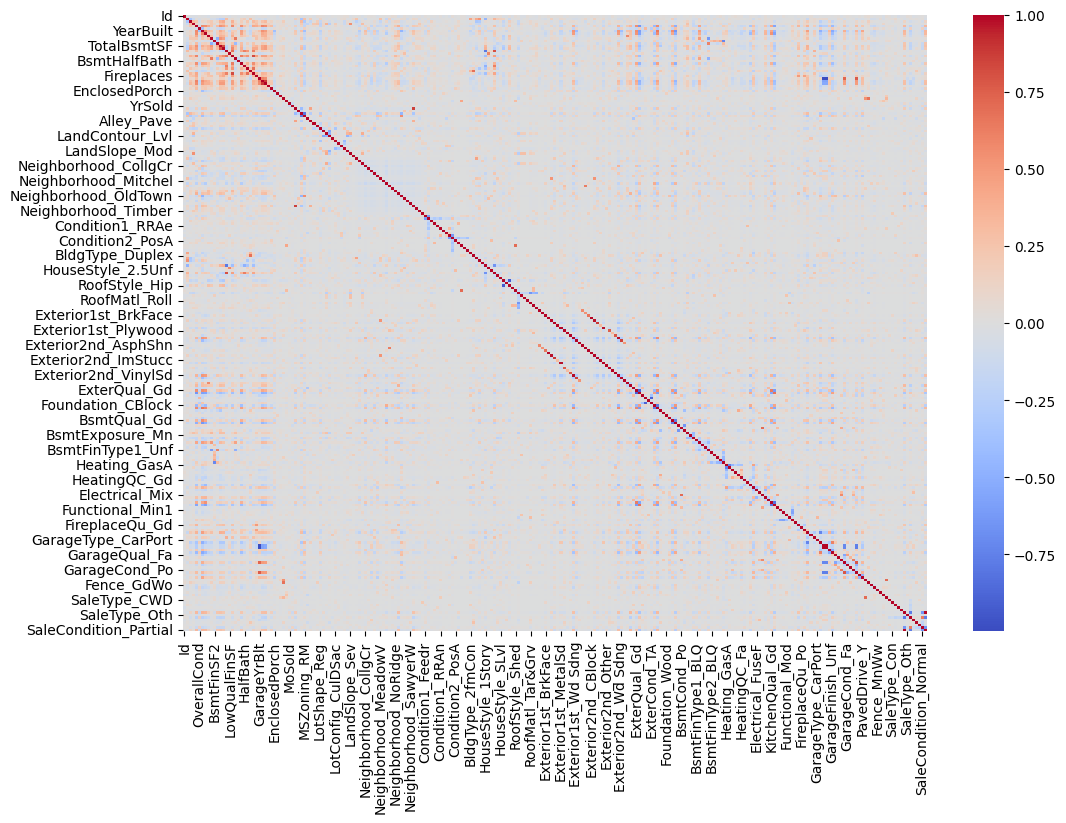

In [12]:
# Feature selection using correlation
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.show()

# Recursive Feature Elimination with Linear Regression
from sklearn.feature_selection import RFE
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=20)
X_selected = rfe.fit_transform(X, y)


**4. Model Build & Evaluation**

With the cleaned and selected features, I trained a Linear Regression model. I split the data into training and testing sets and evaluated the model using metrics like R² and RMSE. To ensure the model's reliability, I performed 5-fold cross-validation, which gave me a better understanding of its performance across different subsets of the data. This step was crucial in identifying any overfitting or underfitting issues.

a) Linear Regression

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train Linear Regression model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression -> R²: {r2:.2f}, RMSE: {rmse:.2f}")


Linear Regression -> R²: 0.62, RMSE: 43373.99


b) K-Fold Cross Validation

In [14]:
cv_scores = cross_val_score(lr, X_selected, y, cv=5, scoring='r2')
print(f"5-Fold CV R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {np.mean(cv_scores):.2f}")


5-Fold CV R² Scores: [0.31246877 0.83326801 0.78352787 0.88450311 0.61002085]
Mean CV R² Score: 0.68


**5. Model Enhancement**

To improve the model, I experimented with Ridge and Lasso regression, which add regularization to control overfitting and highlight important features. Using GridSearchCV, I fine-tuned the alpha parameter for both models to achieve optimal performance. Additionally, I tested Polynomial Regression to capture potential non-linear relationships between features and the target variable. These enhancements provided a deeper understanding of the dataset and improved prediction accuracy.

a) Ridge and Lasso Regression

In [15]:
# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
print(f"Best Ridge Alpha: {ridge_cv.best_params_}")
ridge_best = ridge_cv.best_estimator_

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)
print(f"Best Lasso Alpha: {lasso_cv.best_params_}")
lasso_best = lasso_cv.best_estimator_


Best Ridge Alpha: {'alpha': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e+09, tolerance: 4.171e+08
  model = cd_fast.enet_coordinate_descent(


Best Lasso Alpha: {'alpha': 100}


b) Visualizations

Visualization played a key role in interpreting the results. I created a residual plot to check the model's fit and ensure errors were randomly distributed. A heatmap of feature correlations highlighted multicollinearity, while a bar plot of Ridge coefficients revealed the most influential predictors. I also used SHAP (SHapley Additive exPlanations) to visualize feature importance and dependency, giving clear insights into how individual features affected predictions. These visualizations made the results more interpretable and actionable.

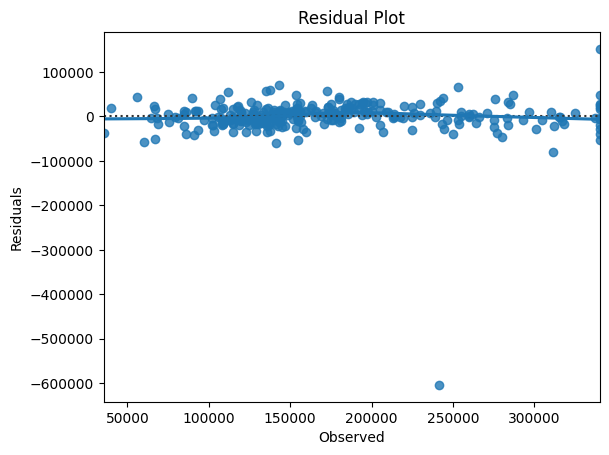

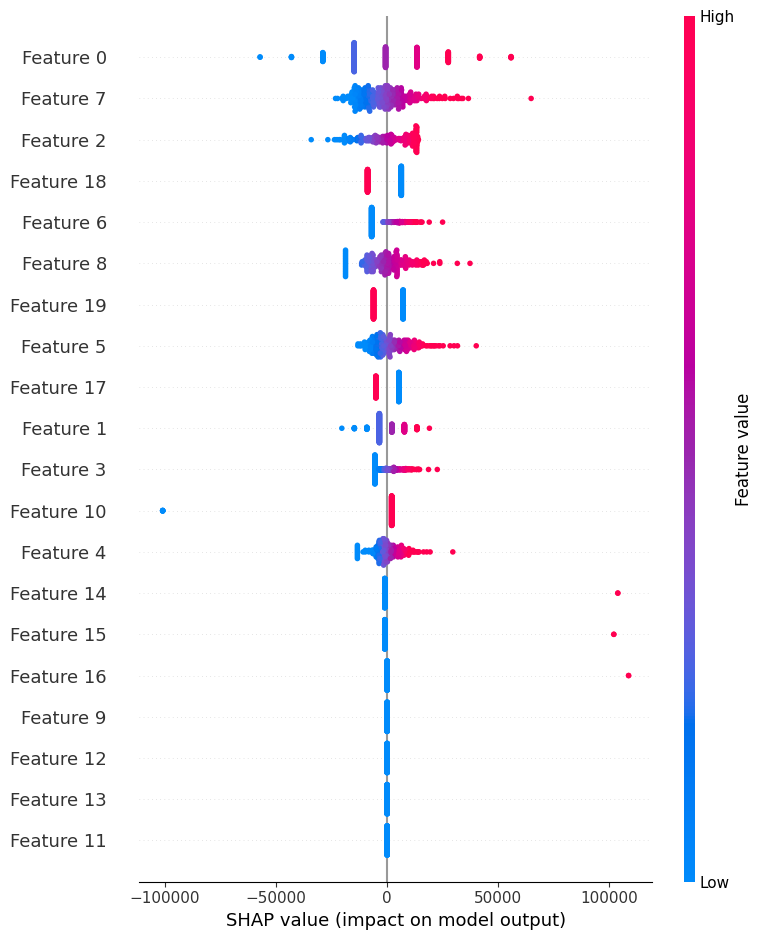

In [16]:
# Residual Plot
sns.residplot(x=y_test, y=y_pred, lowess=True)
plt.xlabel("Observed")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# SHAP Visualization
explainer = shap.Explainer(ridge_best, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


Creativity

1. Polynomial Regression

In [17]:
# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_selected)

# Train Polynomial Regression Model
poly_lr = LinearRegression()
poly_lr.fit(X_train, y_train)
y_poly_pred = poly_lr.predict(X_test)

# Evaluate Polynomial Model
r2_poly = r2_score(y_test, y_poly_pred)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_poly_pred))
print(f"Polynomial Regression -> R²: {r2_poly:.2f}, RMSE: {rmse_poly:.2f}")


Polynomial Regression -> R²: 0.62, RMSE: 43373.99


2. Ridge Regression

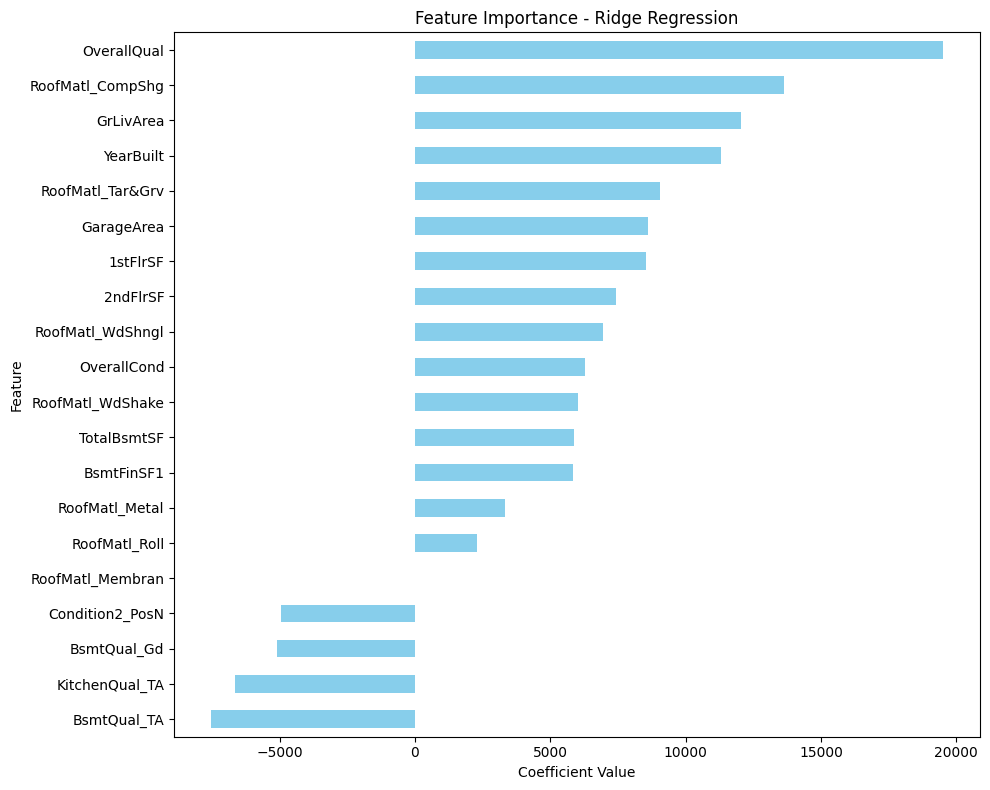

In [18]:
# Get feature importance for Ridge
# Use the selected features for the index
selected_feature_names = X.columns[rfe.support_] # Get the names of selected features
ridge_coef = pd.Series(ridge_best.coef_, index=selected_feature_names).sort_values()

# Plot the coefficients
plt.figure(figsize=(10, 8))
ridge_coef.plot(kind='barh', color='skyblue')
plt.title('Feature Importance - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('ridge_feature_importance.png')
plt.show()

3. Residual vs. Predicted Plot

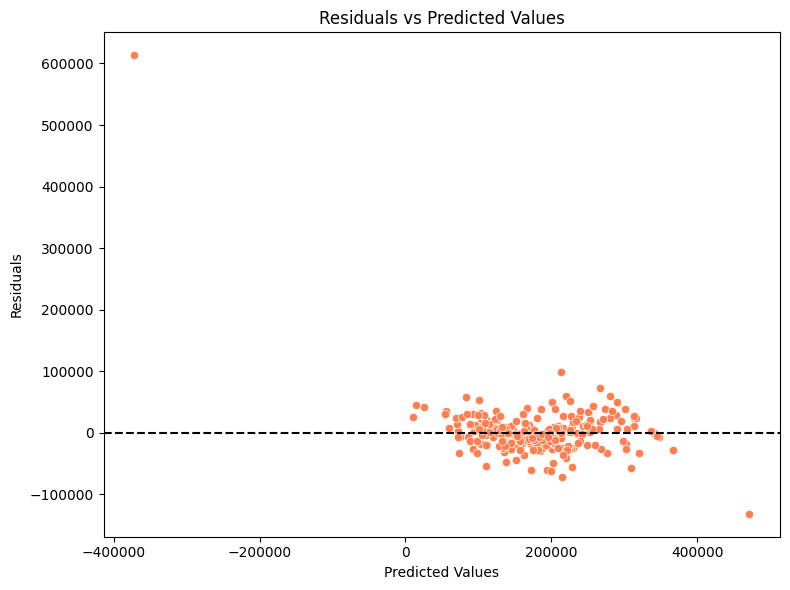

In [19]:
# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, color='coral')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig('residuals_plot.png')
plt.show()


**Conclusion**

Overall, this project allowed me to explore end-to-end regression modeling, from data preprocessing and feature selection to advanced modeling and insightful visualizations. I gained a deeper understanding of how different techniques, such as regularization and SHAP analysis, can enhance both the accuracy and interpretability of regression models. This work not only demonstrated the power of machine learning in predicting house prices but also provided valuable insights into the factors that drive property values.

**Exercise Day 8 : Tree and KNN classification**

In [20]:
#  Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
# Add this import for feature selection
from sklearn.feature_selection import RFE
import shap

# Load the dataset
data = pd.read_csv("train.csv")  # Replace with the path to your dataset
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


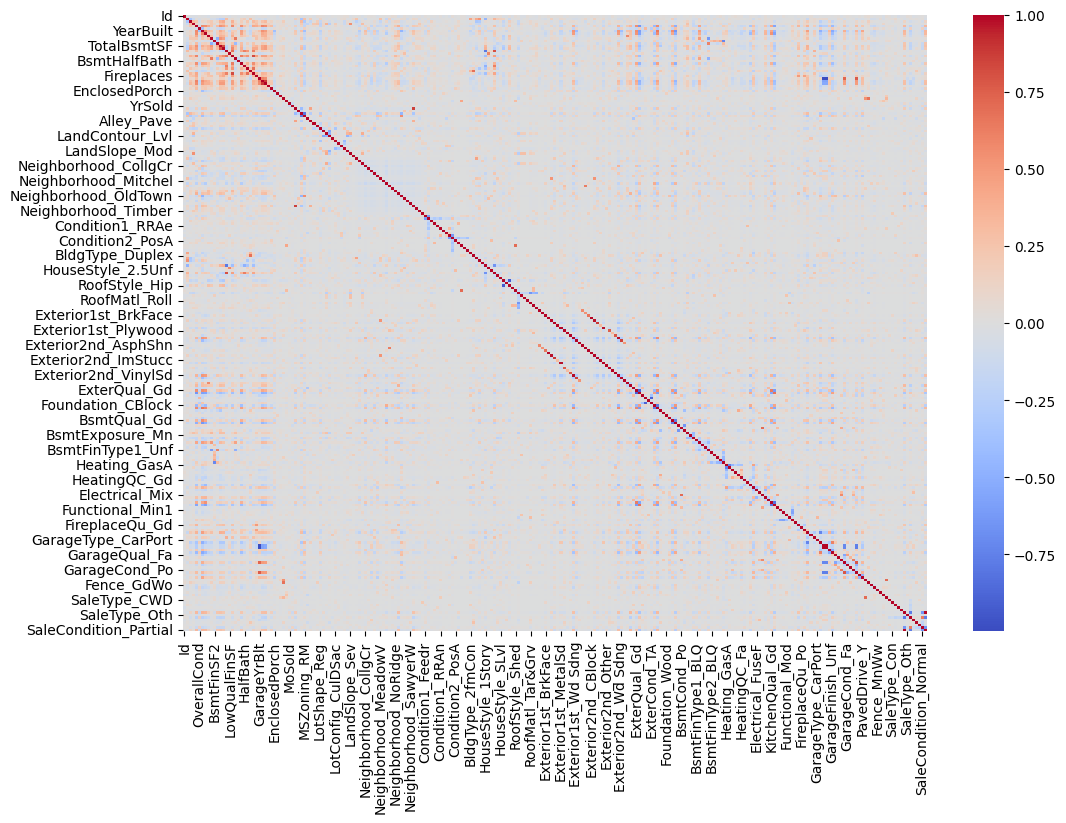

In [21]:
# Feature selection using correlation
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.show()

# Recursive Feature Elimination with Linear Regression
from sklearn.feature_selection import RFE
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=20)
X_selected = rfe.fit_transform(X, y)

Decision Tree Models

In [22]:
# Split data for regression tasks
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test)
r2_tree = r2_score(y_test, y_tree_pred)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_tree_pred))
print(f"Decision Tree -> R²: {r2_tree:.2f}, RMSE: {rmse_tree:.2f}")

# Random Forest Regressor
forest = RandomForestRegressor(random_state=42, n_estimators=100)
forest.fit(X_train, y_train)
y_forest_pred = forest.predict(X_test)
r2_forest = r2_score(y_test, y_forest_pred)
rmse_forest = np.sqrt(mean_squared_error(y_test, y_forest_pred))
print(f"Random Forest -> R²: {r2_forest:.2f}, RMSE: {rmse_forest:.2f}")

# Gradient Boosting Regressor
gboost = GradientBoostingRegressor(random_state=42)
gboost.fit(X_train, y_train)
y_gboost_pred = gboost.predict(X_test)
r2_gboost = r2_score(y_test, y_gboost_pred)
rmse_gboost = np.sqrt(mean_squared_error(y_test, y_gboost_pred))
print(f"Gradient Boosting -> R²: {r2_gboost:.2f}, RMSE: {rmse_gboost:.2f}")


Decision Tree -> R²: 0.79, RMSE: 32111.77
Random Forest -> R²: 0.90, RMSE: 22084.05
Gradient Boosting -> R²: 0.91, RMSE: 21329.58


K-Nearest Neighbours KNN

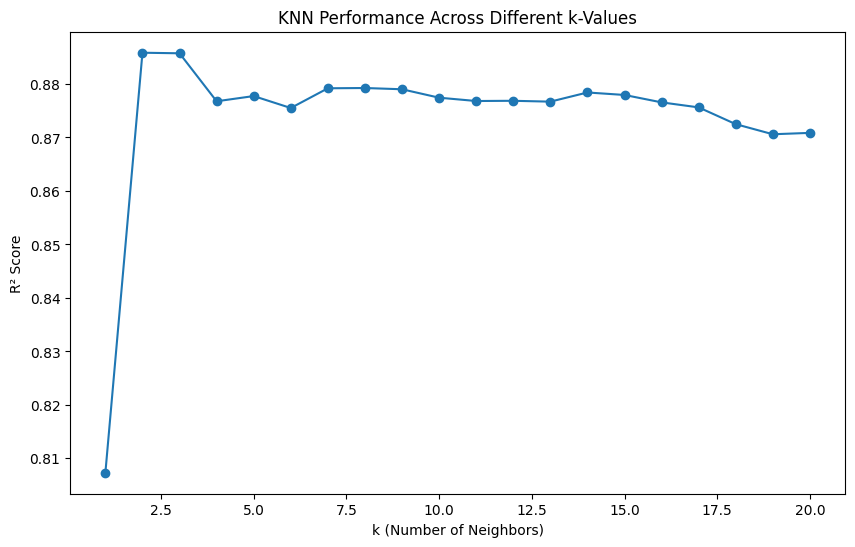

Optimal k for KNN: 2
KNN (k=2) -> R²: 0.89, RMSE: 23625.26


In [23]:
# KNN Regressor
knn_scores = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_knn_pred = knn.predict(X_test)
    knn_scores.append(r2_score(y_test, y_knn_pred))

# Plot performance vs. k-values
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_scores, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("R² Score")
plt.title("KNN Performance Across Different k-Values")
plt.show()

# Optimal k
optimal_k = k_values[np.argmax(knn_scores)]
print(f"Optimal k for KNN: {optimal_k}")

# Best KNN Model
knn_best = KNeighborsRegressor(n_neighbors=optimal_k)
knn_best.fit(X_train, y_train)
y_knn_best_pred = knn_best.predict(X_test)
r2_knn_best = r2_score(y_test, y_knn_best_pred)
rmse_knn_best = np.sqrt(mean_squared_error(y_test, y_knn_best_pred))
print(f"KNN (k={optimal_k}) -> R²: {r2_knn_best:.2f}, RMSE: {rmse_knn_best:.2f}")


Evaluation Metrics

In [24]:
# Convert regression predictions to classification outputs for evaluation
y_test_class = pd.qcut(y_test, q=4, labels=[0, 1, 2, 3])
y_pred_class_tree = pd.qcut(y_tree_pred, q=4, labels=[0, 1, 2, 3])
y_pred_class_forest = pd.qcut(y_forest_pred, q=4, labels=[0, 1, 2, 3])
y_pred_class_gboost = pd.qcut(y_gboost_pred, q=4, labels=[0, 1, 2, 3])
y_pred_class_knn = pd.qcut(y_knn_best_pred, q=4, labels=[0, 1, 2, 3])

# Calculate evaluation metrics for each model
def evaluate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} -> Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Evaluate all models
evaluate_metrics(y_test_class, y_pred_class_tree, "Decision Tree")
evaluate_metrics(y_test_class, y_pred_class_forest, "Random Forest")
evaluate_metrics(y_test_class, y_pred_class_gboost, "Gradient Boosting")
evaluate_metrics(y_test_class, y_pred_class_knn, "KNN")


Decision Tree -> Accuracy: 0.66, Precision: 0.66, Recall: 0.66, F1-Score: 0.66
Random Forest -> Accuracy: 0.74, Precision: 0.74, Recall: 0.74, F1-Score: 0.74
Gradient Boosting -> Accuracy: 0.76, Precision: 0.76, Recall: 0.76, F1-Score: 0.76
KNN -> Accuracy: 0.73, Precision: 0.73, Recall: 0.73, F1-Score: 0.73
